In [408]:
import timeit
import random
import pandas as pd
from random import sample
import math
import matplotlib.pyplot as plt
import numpy as np

temperature = 1                 # initial temperature to start anneal with
alpha = 0.9999                  # fraction by which temperature is reduced in each iteration
minimum_temperature = 0.00001   # threshold for stopping iterations once temperature is very low
number_of_iterations = 1000
number_of_nodes = 101            # customer size (upto '400')

In [409]:
''' following function generates coordinates (x,y) of 'n' customer nodes in a [n,2] array '''

def generateCoordinates():
    #data = pd.read_csv('MVRP_400N.txt', ' ')
    data = pd.read_csv('RC201.csv', ',')
    df = pd.DataFrame(data)
    coordinates = np.empty([number_of_nodes, 2])
    for i in range(number_of_nodes):
        for j in range(2):
            coordinates[i, 0] = df["X"][i]
            coordinates[i, 1] = df["Y"][i]
    return coordinates


coordinates = generateCoordinates()


''' this class passes coordinates of customer grid and do distance calculations between nodes '''

class distances:

    def __init__(self, coordinates):
        self.grid = coordinates
        self.distance_grid = np.empty((len(self.grid), len(self.grid)))

    ''' following function is to create 'n' by 'n' array storing distance from one node to other in respective cells'''

    def distance_matrix(self):
        for i in range(len(self.grid)):
            for j in range(len(self.grid)):
                self.distance_grid[i, j] = math.sqrt(
                    ((self.grid[i][0] - self.grid[j][0]) ** 2 + (self.grid[i][1] - self.grid[j][1]) ** 2))
        return self.distance_grid

    def get_distance_matrix(self):
        return self.distance_matrix()

    def distance(self, node1, node2):
        return self.distance_grid[node1, node2]

    ''' calculating total distance in a tour'''

    def tour_cost(self, tour=[]):
        total_distance = 0
        for i in range(len(tour) - 1):
            total_distance += self.distance_grid[tour[i], tour[i + 1]]
        total_distance += self.distance_grid[tour[len(tour) - 1], tour[0]]
        return total_distance

    ''' passes list of nodes in a tour and returns respective coordinates of customer nodes'''

    def generate_coordinates(self, tour=[]):
        tour_coordinates = np.empty([len(tour), 2])
        for i in range(len(tour)):
            for j in range(2):
                tour_coordinates[i, j] = self.grid[tour[i], j]
        return tour_coordinates.astype('int')

In [410]:
''' nearest neighbor as a greedy heuristic to create initial good solution'''

class nearestNeighborSearch:

    def __init__(self, coordinates):
        self.coordinates = coordinates
        self.solution = []

    def NNS(self):
        self.N = len(self.coordinates)
        free_nodes = []
        dist = distances(self.coordinates)
        dist.get_distance_matrix()
        for i in range(self.N - 1):
            free_nodes.append(i + 1)
        current_node = 0
        self.solution = [current_node]
        while free_nodes:
            next_node = min(
                free_nodes, key=lambda x: dist.distance(current_node, x))
            free_nodes.remove(next_node)
            self.solution.append(next_node)
            current_node = next_node
        return self.solution

In [424]:
#@title Default title text
''' simulated annealing to improve initial solution achieved from NNS,
it iterates with declining temperature of annealing, escaping local optima and
trying to locate global optima within threshold values '''


class simulatedAnnealing:

    def __init__(self, t0, iterations, alpha, least_temp, coordinates):
        self.init_temp = t0
        self.num_iter = iterations
        self.temp_threshold = least_temp
        self.temp_fraction = alpha
        self.coordinates = coordinates
        self.num_nodes = len(self.coordinates)
        self.best_tour = []
        self.explored_tour = []

# next state is generated by altering previous tour by reversing a segment of route from a customer to another customer

    def generate_state(self, tour=[]):
        new_tour = list(tour)
        l = random.randint(1, len(tour) - 1)
        i = random.randint(1, len(tour) - l)
        new_tour[i: (i + l)] = reversed(new_tour[i: (i + l)])
        #new_tour[i] = new_tour[l]
        #
        return new_tour

    def SA(self):
        temp = self.init_temp
        nns = nearestNeighborSearch(coordinates)
        dist = distances(coordinates)
        dist.get_distance_matrix()
        current_tour = nns.NNS()
        multiples_iterator = [n for n in range(1, self.num_iter+1) if n % 10 == 0]
        self.best_tour = current_tour
        self.explored_tour.append(current_tour)
        self.best_tempr = 0
        self.iter_to_opt = 0
        for i in range(self.num_iter):
            new_tour = self.generate_state(current_tour)
            if new_tour not in self.explored_tour and temp >= self.temp_threshold:
                self.explored_tour.append(new_tour)
                d1 = dist.tour_cost(current_tour)
                d2 = dist.tour_cost(new_tour)
                if d1 >= d2:  # if new solution is better than previous one, accept it right away
                    for i in range(len(new_tour)):
                        current_tour = new_tour
                else:
                    delta = d2 - d1
                    # calculate probability if new solution is not better than previous
                    probability = np.exp(-delta / temp)
                    # keep solution if probability is better than a random probability between 0 and 1.
                    if probability >= np.random.normal(0.50, 0.005):
                        current_tour = new_tour
                if dist.tour_cost(current_tour) <= dist.tour_cost(self.best_tour):
                    self.best_tour = current_tour
                    self.best_tempr = temp
                    self.iter_to_opt = i
                # reduce temperature for next iteration by pre-defined fraction.
                temp *= self.temp_fraction

            #Add iteration increment by 10
            for n in range(len(multiples_iterator)):
              if i == multiples_iterator[n]:
                if i == len(multiples_iterator):
                  continue
                print('\nBest objective function', i, 'is:' , dist.tour_cost(self.best_tour))
                print('\nBest tour found is:', self.best_tour)

        return self.best_tour, dist.tour_cost(self.best_tour), self.best_tempr, self.iter_to_opt

In [412]:
tsp = simulatedAnnealing(temperature, number_of_iterations,alpha, minimum_temperature, coordinates)
dist = distances(coordinates)
dist.get_distance_matrix()
nns = nearestNeighborSearch(coordinates)
nns.NNS()
start_sa = timeit.default_timer()
tsp.SA()
end_sa = timeit.default_timer()
start_nns = timeit.default_timer()
print('\nInitial solution by NNS is:', dist.tour_cost(nns.solution))
end_nns = timeit.default_timer()
print('\nInitial solution tour by NNS is:', nns.NNS())
print('\nBest tour found by SA is:', tsp.best_tour)
print('\nMinimum distance covered is:', dist.tour_cost(tsp.best_tour))
print('\nBest temperature to get optimal solution:', tsp.best_tempr)
print('\nIterations completed to get optimal solution:', tsp.iter_to_opt)
print('\nSolution improved by SA is:', dist.tour_cost(
    nns.solution) - dist.tour_cost(tsp.best_tour))
print('\nTime taken by NNS is:', end_nns - start_nns)
print('\nTime taken by SA is:', end_sa - start_sa)




Best objective function 10 is: 732.1457675536518

Best tour found is: [0, 90, 65, 66, 83, 64, 56, 95, 92, 91, 80, 94, 93, 71, 96, 54, 81, 61, 68, 55, 88, 98, 69, 82, 99, 52, 57, 86, 74, 87, 59, 97, 75, 58, 77, 25, 23, 21, 48, 18, 19, 49, 20, 22, 24, 51, 85, 63, 76, 89, 84, 62, 50, 67, 34, 31, 29, 27, 26, 28, 30, 32, 33, 72, 41, 39, 38, 37, 36, 35, 40, 43, 44, 42, 70, 100, 2, 6, 7, 8, 46, 4, 45, 5, 3, 1, 79, 73, 78, 60, 53, 12, 14, 47, 17, 16, 15, 13, 9, 10, 11]

Best objective function 20 is: 732.1457675536518

Best tour found is: [0, 90, 65, 66, 83, 64, 56, 95, 92, 91, 80, 94, 93, 71, 96, 54, 81, 61, 68, 55, 88, 98, 69, 82, 99, 52, 57, 86, 74, 87, 59, 97, 75, 58, 77, 25, 23, 21, 48, 18, 19, 49, 20, 22, 24, 51, 85, 63, 76, 89, 84, 62, 50, 67, 34, 31, 29, 27, 26, 28, 30, 32, 33, 72, 41, 39, 38, 37, 36, 35, 40, 43, 44, 42, 70, 100, 2, 6, 7, 8, 46, 4, 45, 5, 3, 1, 79, 73, 78, 60, 53, 12, 14, 47, 17, 16, 15, 13, 9, 10, 11]

Best objective function 30 is: 732.1457675536518

Best tour found

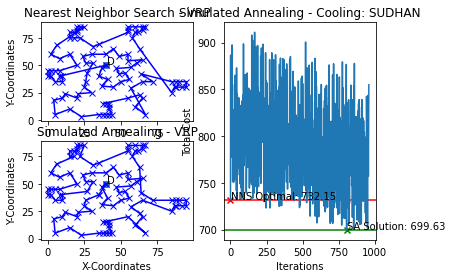

In [413]:
'''for simplicity, the following function plots all components line by line '''

def plotSA():
    dist_list = []
    dist = distances(coordinates)
    dist.get_distance_matrix()
    x = []
    for i in range(len(tsp.explored_tour)):
        x.append(i)
    for i in tsp.explored_tour:
        dist_list.append(dist.tour_cost(i))
    xx, yy = dist.generate_coordinates(tsp.best_tour)[:, 0],  dist.generate_coordinates(tsp.best_tour)[:, 1]
    depot = tsp.coordinates[0]
    _xx, _yy = [xx[0], xx[tsp.num_nodes - 1]], [yy[0], yy[tsp.num_nodes - 1]]

    plt.subplot(2, 2, 1)
    plt.scatter(depot[0], depot[1], marker='o')
    plt.plot([dist.generate_coordinates(nns.solution)[:, 0][0], dist.generate_coordinates(nns.solution)[:, 0][tsp.num_nodes - 1]],[dist.generate_coordinates(nns.solution)[:, 1][0], dist.generate_coordinates(nns.solution)[:, 1][tsp.num_nodes - 1]], 'x-', color='b')
    plt.plot(dist.generate_coordinates(nns.solution)[:, 0], dist.generate_coordinates(nns.solution)[:, 1], 'x-', color='b')
    plt.text(depot[0] + 0.5, depot[1] + 0.5, str('D')), plt.title('Nearest Neighbor Search - VRP'), plt.ylabel('Y-Coordinates')

    plt.subplot(2, 2, 3)
    plt.scatter(depot[0], depot[1], marker='o')
    plt.plot(_xx, _yy, 'x-', color='b')
    plt.plot(xx, yy, 'x-', color='b')
    plt.text(depot[0] + 0.5, depot[1] + 0.5, str('D')), plt.title('Simulated Annealing - VRP'), plt.xlabel('X-Coordinates'), plt.ylabel('Y-Coordinates')

    plt.subplot(1, 2, 2)
    plt.scatter(dist_list.index(min(dist_list)),min(dist_list), color='g', marker='x')
    plt.axhline(y=min(dist_list), color='g',linestyle='-', label='SA Solution')
    plt.text(dist_list.index(min(dist_list)) + 1, min(dist_list) +0.5, 'SA Solution:' + ' ' + str(round(min(dist_list), 2)))
    plt.axhline(y=dist.tour_cost(nns.solution), color='r',linestyle='-', label='NNS Solution')
    plt.scatter(0, dist.tour_cost(nns.solution), color='r', marker='x')
    plt.text(1, dist.tour_cost(nns.solution) + 0.5, 'NNS Optimal:' +' ' + str(round(dist.tour_cost(nns.solution), 2)))
    plt.plot(x, dist_list)
    plt.title('Simulated Annealing - Cooling: SUDHAN'), plt.xlabel('Iterations'), plt.ylabel('Total Cost')
    plt.show()


graph = plotSA()

In [414]:
number_of_iterations = 1000
multiples_iterator = [n for n in range(1, number_of_iterations) if n % 10 == 0]
multiples_iterator

[10,
 20,
 30,
 40,
 50,
 60,
 70,
 80,
 90,
 100,
 110,
 120,
 130,
 140,
 150,
 160,
 170,
 180,
 190,
 200,
 210,
 220,
 230,
 240,
 250,
 260,
 270,
 280,
 290,
 300,
 310,
 320,
 330,
 340,
 350,
 360,
 370,
 380,
 390,
 400,
 410,
 420,
 430,
 440,
 450,
 460,
 470,
 480,
 490,
 500,
 510,
 520,
 530,
 540,
 550,
 560,
 570,
 580,
 590,
 600,
 610,
 620,
 630,
 640,
 650,
 660,
 670,
 680,
 690,
 700,
 710,
 720,
 730,
 740,
 750,
 760,
 770,
 780,
 790,
 800,
 810,
 820,
 830,
 840,
 850,
 860,
 870,
 880,
 890,
 900,
 910,
 920,
 930,
 940,
 950,
 960,
 970,
 980,
 990]

In [415]:
x = len(multiples_iterator)
x

99

In [416]:
multiples_iterator[9]

100

In [417]:
tour = [0, 80, 79, 77, 73, 70, 71, 76, 78, 81, 85, 84, 83, 82, 86, 87, 91, 12, 14, 16, 15, 19, 18, 17, 13, 75, 3, 5, 7, 8, 10, 11, 9, 6, 4, 1, 2, 99, 100, 97, 93, 92, 94, 95, 96, 98, 88, 89, 90, 63, 65, 67, 69, 66, 62, 74, 72, 61, 64, 68, 60, 58, 56, 53, 54, 55, 57, 59, 51, 50, 48, 46, 45, 44, 40, 41, 42, 43, 47, 49, 52, 33, 32, 31, 35, 37, 38, 39, 36, 34, 30, 29, 24, 25, 27, 28, 26, 23, 22, 21, 20]
new_tour = list(tour)
l = random.randint(1, len(tour) - 1)
i = random.randint(1, len(tour) - l)
new_tour[i: (i + l)] = reversed(new_tour[i: (i + l)])

In [418]:
l

46

In [419]:
i

32

In [420]:
new_tour

[0,
 80,
 79,
 77,
 73,
 70,
 71,
 76,
 78,
 81,
 85,
 84,
 83,
 82,
 86,
 87,
 91,
 12,
 14,
 16,
 15,
 19,
 18,
 17,
 13,
 75,
 3,
 5,
 7,
 8,
 10,
 11,
 43,
 42,
 41,
 40,
 44,
 45,
 46,
 48,
 50,
 51,
 59,
 57,
 55,
 54,
 53,
 56,
 58,
 60,
 68,
 64,
 61,
 72,
 74,
 62,
 66,
 69,
 67,
 65,
 63,
 90,
 89,
 88,
 98,
 96,
 95,
 94,
 92,
 93,
 97,
 100,
 99,
 2,
 1,
 4,
 6,
 9,
 47,
 49,
 52,
 33,
 32,
 31,
 35,
 37,
 38,
 39,
 36,
 34,
 30,
 29,
 24,
 25,
 27,
 28,
 26,
 23,
 22,
 21,
 20]

In [421]:
y = [0, 80, 79, 77, 73, 70, 71, 76, 78, 81, 85, 84, 83, 82, 86, 87, 91, 12, 14, 16, 15, 19, 18, 17, 13, 6, 9, 11, 10, 8, 7, 5, 3, 75, 4, 1, 2, 99, 100, 97, 93, 92, 94, 95, 96, 98, 88, 89, 90, 63, 65, 67, 69, 66, 62, 74, 72, 61, 64, 68, 60, 58, 56, 53, 54, 55, 57, 59, 51, 50, 48, 46, 45, 44, 40, 41, 42, 43, 47, 49, 52, 33, 32, 31, 35, 37, 38, 39, 36, 34, 30, 29, 24, 25, 27, 28, 26, 23, 22, 21, 20]
x = [0, 80, 79, 77, 73, 70, 71, 76, 78, 81, 85, 84, 83, 82, 86, 87, 91, 12, 14, 16, 15, 19, 18, 17, 13, 75, 3, 5, 7, 8, 10, 11, 9, 6, 4, 1, 2, 99, 100, 97, 93, 92, 94, 95, 96, 98, 88, 89, 90, 63, 65, 67, 69, 66, 62, 74, 72, 61, 64, 68, 60, 58, 56, 53, 54, 55, 57, 59, 51, 50, 48, 46, 45, 44, 40, 41, 42, 43, 47, 49, 52, 33, 32, 31, 35, 37, 38, 39, 36, 34, 30, 29, 24, 25, 27, 28, 26, 23, 22, 21, 20]

In [422]:
new_tour[9], new_tour[25] = new_tour[25], new_tour[9]

In [423]:
y = np.array(new_tour)
y

array([  0,  80,  79,  77,  73,  70,  71,  76,  78,  75,  85,  84,  83,
        82,  86,  87,  91,  12,  14,  16,  15,  19,  18,  17,  13,  81,
         3,   5,   7,   8,  10,  11,  43,  42,  41,  40,  44,  45,  46,
        48,  50,  51,  59,  57,  55,  54,  53,  56,  58,  60,  68,  64,
        61,  72,  74,  62,  66,  69,  67,  65,  63,  90,  89,  88,  98,
        96,  95,  94,  92,  93,  97, 100,  99,   2,   1,   4,   6,   9,
        47,  49,  52,  33,  32,  31,  35,  37,  38,  39,  36,  34,  30,
        29,  24,  25,  27,  28,  26,  23,  22,  21,  20])